# Arbres de Desicions

Un arbre de décision est un modèle de classification hiérarchique : pour des exemples sous la représentation x = (x1; x2; : : : ; xd) 2 Rd, à chaque nœud de l’arbre est associé un test sur une des dimensions
xi de la forme xi ≤ s avec s une valeur réelle. Ce test indique le nœud fils qui doit être sélectionné (par
exemple pour un arbre binaire, le fils gauche quand le test est vrai, le fils droit sinon). À chaque feuille
de l’arbre est associée une étiquette. Ainsi, la classification d’un exemple consiste en une succession de
tests sur les valeurs des dimensions de l’exemple, selon un chemin dans l’arbre de la racine à une des
feuilles. La feuille atteinte donne la classe prédite.

L’apprentissage de l’arbre s’effectue de manière récursive gloutonne top-down : à chaque nœud, l’algorithme doit choisir un test optimal, c’est-à-dire à la fois sur quelle dimension faire le test et quel
seuillage appliqué (ce qu’on appelle un split). La mesure d’optimalité est en général une mesure d’homogénéité sur la partition obtenue, usuellement l’entropie de Shanon ou l’index de Gini : l’entropie
d’une partition est d’autant plus petite qu’une classe prédomine dans chaque sous-ensemble de la partition, elle est nulle lorsque la séparation est parfaite (un seul label présent dans chacune des partitions)
et maximale lorsque l’ensemble est le plus désordonné possible (équiprobabilité des labels dans chaque
partition).

Pour calculer le split optimal, chaque dimension de l’espace de description est considérée itérativement ;
pour une dimension i, les exemples sont triés par rapport à la valeur de l’attribut de cette dimension
xi, puis pour chaque split possible, le calcul de l’homogénéité des deux partitions obtenues (en termes
de label) par ce split est effectué. Le split ayant la meilleure homogénéité est alors choisi.
Bien que l’algorithme pourrait continuer récursivement jusqu’à n’obtenir que des feuilles contenant un
ensemble pur d’exemples (d’une seule classe), on utilise souvent des critères d’arrêts (pourquoi ? - nous
y reviendrons lors de ce TP). Les plus utilisés sont le nombre d’exemples minimum que doit contenir
un nœud pour être divisé (critère local) et la profondeur maximale de l’arbre (critère global)

In [1]:
%load_ext autoreload

import numpy as np
from graphviz import Source
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier as DTree
from sklearn.ensemble import RandomForestClassifier as RFC
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
import sys
import os

%autoreload 2
sys.path.append("../")
from utils import imdb

In [2]:
#load it
datax, datay, id2titles, fields = imdb.load_data()
print("datasetSize: ", datax.shape[0])
print("numberOfFeatures : ", datax.shape[1])
print("Y labels have values of : ", np.unique(datay))
print()
print("Fields dictionary : ", fields)
print()
display(id2titles)

datasetSize:  4587
numberOfFeatures :  33
Y labels have values of :  [-1  1]

Fields dictionary :  {0: 'Sci-Fi', 1: 'Crime', 2: 'Romance', 3: 'Animation', 4: 'Music', 5: 'Comedy', 6: 'War', 7: 'Horror', 8: 'Film-Noir', 9: 'Adult', 10: 'News', 11: 'Reality-TV', 12: 'Thriller', 13: 'Western', 14: 'Mystery', 15: 'Short', 16: 'Talk-Show', 17: 'Drama', 18: 'Action', 19: 'Documentary', 20: 'Musical', 21: 'History', 22: 'Family', 23: 'Adventure', 24: 'Fantasy', 25: 'Game-Show', 26: 'Sport', 27: 'Biography', 28: 'Duree', 29: 'couleur', 30: 'annee', 31: 'budget', 32: 'nb_votes', 33: 'rating'}



{0: "'Crocodile' Dundee II",
 1: '(500) Days of Summer',
 2: "...E tu vivrai nel terrore! L'aldilà",
 3: '10 Things I Hate About You',
 4: '10,000 BC',
 5: '101 Dalmatians',
 6: '102 Dalmatians',
 7: '11:14',
 8: '12',
 9: '12 Angry Men',
 10: '12 Rounds',
 11: '12 Years a Slave',
 12: '127 Hours',
 13: '13 Going on 30',
 14: '13 Sins',
 15: '1408',
 16: '1492: Conquest of Paradise',
 17: '15 Minutes',
 18: '16 Blocks',
 19: '17 Again',
 20: '1941',
 21: '2 Days in New York',
 22: '2 Fast 2 Furious',
 23: '2 Guns',
 24: '20,000 Leagues Under the Sea',
 25: '200 Cigarettes',
 26: '2001 Maniacs',
 27: '2001: A Space Odyssey',
 28: '2010',
 29: '2012',
 30: '2046',
 31: '21 & Over',
 32: '21',
 33: '21 Grams',
 34: '21 Jump Street',
 35: '22 Jump Street',
 36: '25th Hour',
 37: '27 Dresses',
 38: '28 Days',
 39: '28 Days Later...',
 40: '3 Days to Kill',
 41: '3 Men and a Baby',
 42: '3 Ninjas',
 43: '30 Days of Night',
 44: '30 Minutes or Less',
 45: '300',
 46: '3000 Miles to Graceland'

In [3]:
df = pd.DataFrame(np.hstack((datax, datay.reshape(-1, 1))), columns=fields.values())
clean = df.drop(['Adult', 'News', 'Reality-TV', 'Talk-Show', 'Game-Show'], axis=1)

In [4]:
corr = clean.corr()

In [5]:
#corr2 = clean.fillna(0)

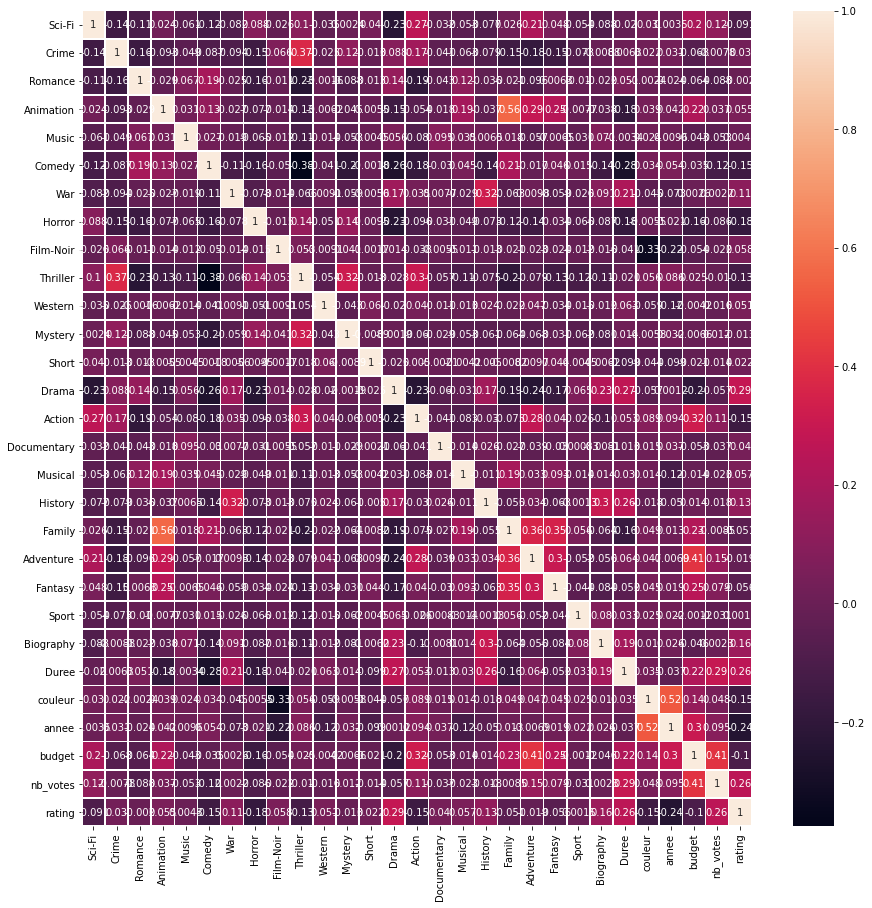

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
sn.heatmap(corr, annot=True, linewidths=.5, ax=ax)
plt.show()

### Exercice 1: Entropie

Dans cette partie nous allons coder quelques fonctions utilitaire notemment l'entropie.

l'entropie est définie par : $$H(Y) = -\sum_{y\in Y}{p_y \log{p_y}}$$ où $p_y$  designe la probabilité du label y dans le dataset 

In [7]:
def entropie(vect):
    """
    Array->float
    
    Calcule l'entropie d'un vecteur
    """
    Y, py = np.unique(vect, return_counts=True)
    py = py/py.sum() # normaliser
    
    py[py==0] = 1 # pour eviter les erreurs floatants

    return -py.dot(np.log(py))


print(f"test 1 : {entropie(np.arange(10))}, expected: {np.log(10)}")
print(f"test 1 : {entropie(np.array([1]*10))}, expected: 0")

test 1 : 2.3025850929940455, expected: 2.302585092994046
test 1 : -0.0, expected: 0


L’entropie conditionnelle permet de calculer l’homogénéité de la partition obtenue.

Dans le cas général d’un split n-aire en n partitions P = fP1; : : : ; Png, l’entropie conditionnelle à P s’écrit: 

$$H(Y|P) = \sum_{i}{p(P_i)H(Y|P_i)}, \\ H(Y|P_i) = − \sum_{y \in Y}{p(y|Pi)\log(p(y|P_i))}$$ l’entropie des labels conditionnée à la partition considérée, et p(Pi) = PjjPjiPj jj, la proportion d’éléments dans Pi. Il s’agit en fait
de la moyenne pondérée des entropies des sous-ensembles obtenus.

In [8]:
def etropie_cond(vect):
    """
    """
    
    return 0

### Experiments

In [32]:
dt = DTree ()
dt.max_depth = 5 #on fixe la taille max de l’arbre a 5
dt.min_samples_split = 2 # nombre minimum d’exemples pour spliter un noeud
dt.fit(df.iloc[:, :-1] , df.iloc[:, -1] )

print (dt.score(df.iloc[:, :-1] , df.iloc[:, -1] ))
# dessine l’arbre dans un fichier pdf si pydot est installe .
export_graphviz (dt,
                 out_file ="tree.dot ",
                 feature_names = df.columns[:-1],
                 class_names = ["Bad", "Good"],
                 rounded = True,
                 filled= True)

0.7931109657728362


In [33]:
!dot -Tpng tree.dot -o tree.png

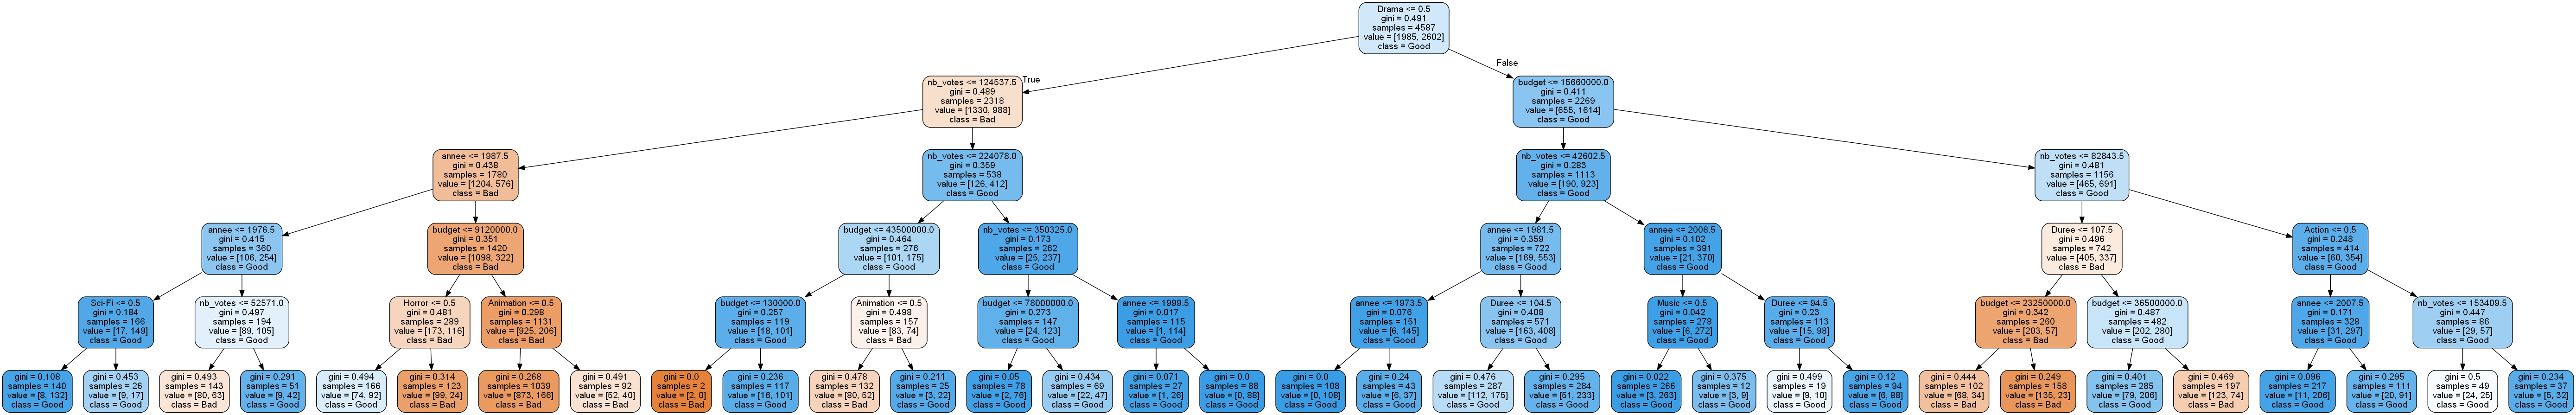

In [34]:
from IPython.display import Image
Image(filename='tree.png', embed=True) 

In [35]:
# Let's split the data to train and test
from sklearn.model_selection import StratifiedShuffleSplit

#first we create a category for the median income, so that when we split, we're garanted to obtain a representative test set

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
split.split(datax, datay)
# for train_index, test_index in split.split(datax, datay):
#     strat_train_set = housing_data.loc[train_index]
#     strat_test_set  = housing_data.loc[test_index]  

<generator object BaseShuffleSplit.split at 0x0000023B22433900>

train score :  0.7980376124284546
teest score :  0.7886710239651417


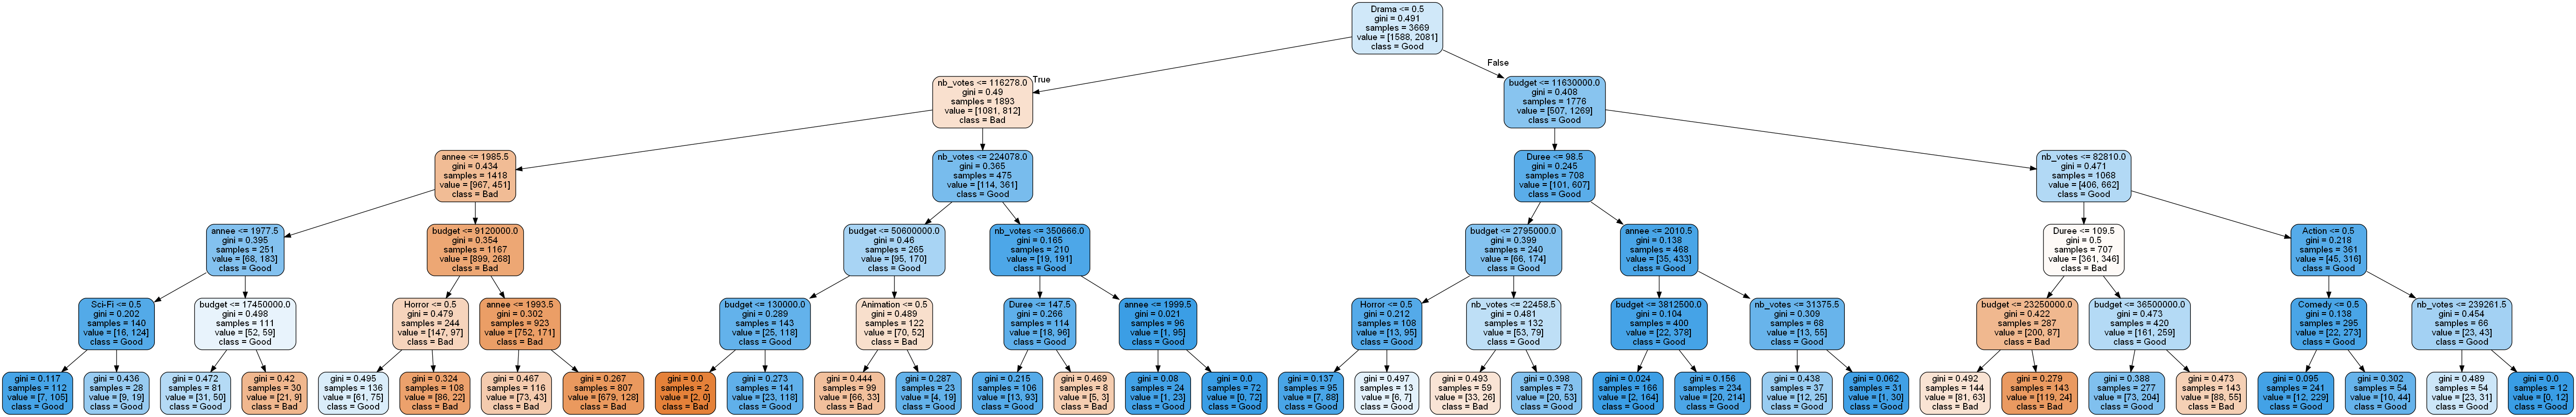

In [45]:
for train_index, test_index in split.split(datax, datay):
    dt = DTree (max_depth=5, min_samples_split=2)
    dt.fit(df.iloc[train_index, :-1] , df.iloc[train_index, -1] )

    
    print ("train score : ", dt.score(df.iloc[train_index, :-1] , df.iloc[train_index, -1] ))
    print ("teest score : ", dt.score(df.iloc[test_index, :-1] , df.iloc[test_index, -1] ))
    # dessine l’arbre dans un fichier pdf si pydot est installe .
    export_graphviz (dt,
                     out_file ="train_test.dot ",
                     feature_names = df.columns[:-1],
                     class_names = ["Bad", "Good"],
                     rounded = True,
                     filled= True)
    !dot -Tpng train_test.dot -o train_test.png
    display(Image(filename='train_test.png', embed=True))

train score :  0.695


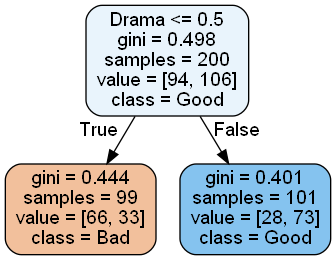

train score :  0.775


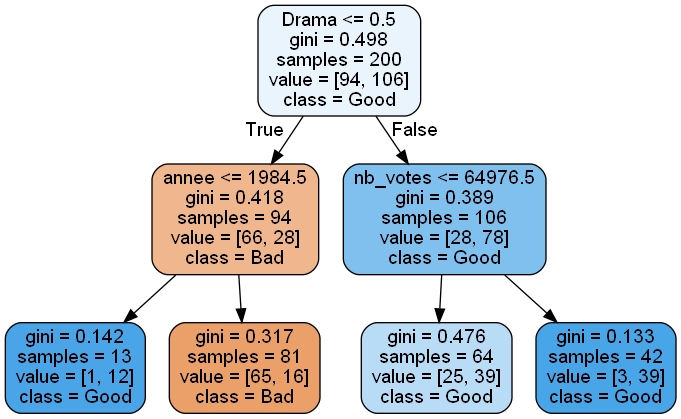

train score :  0.835


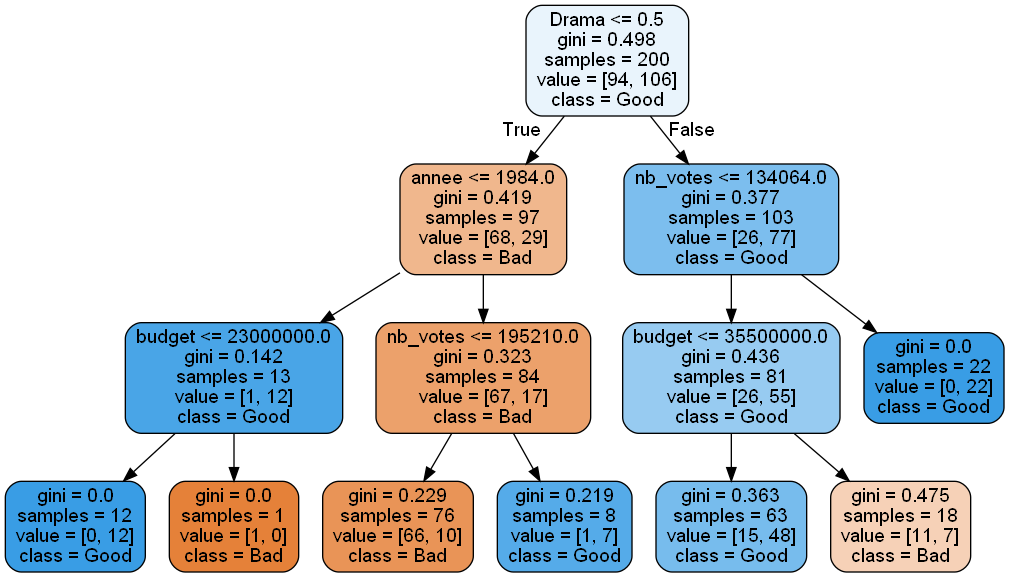

train score :  0.845


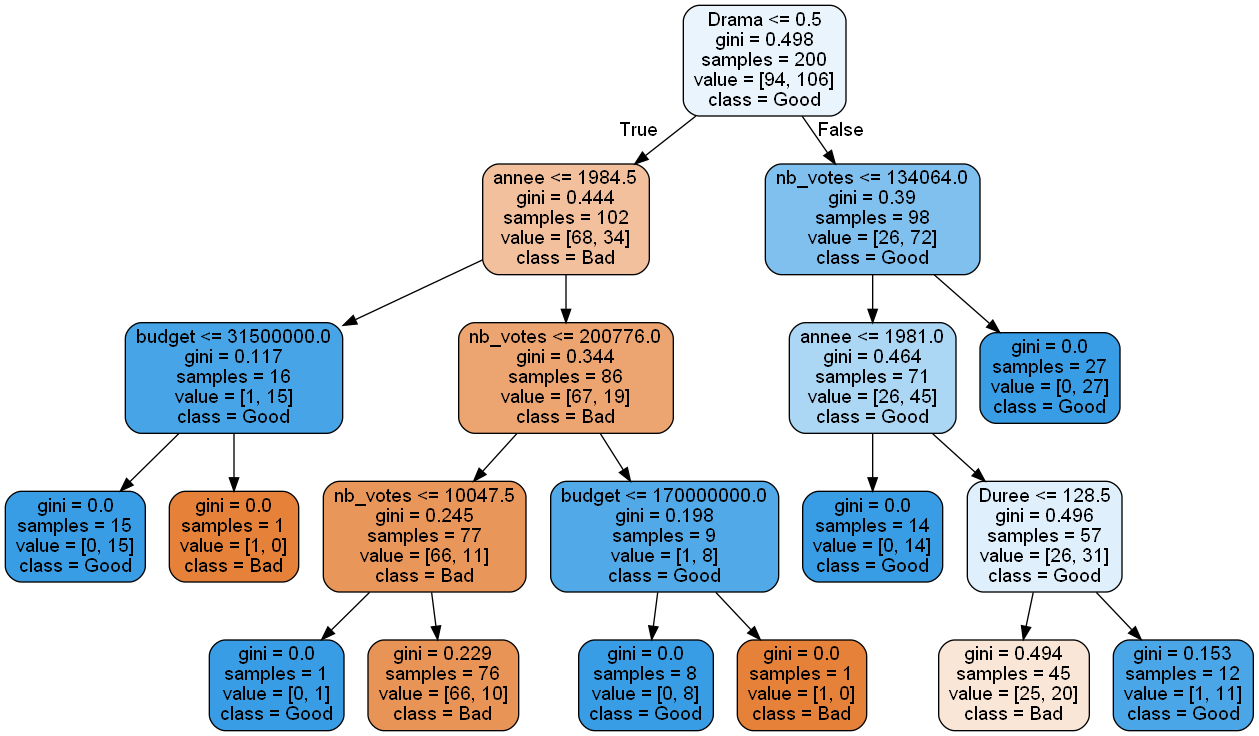

train score :  0.905


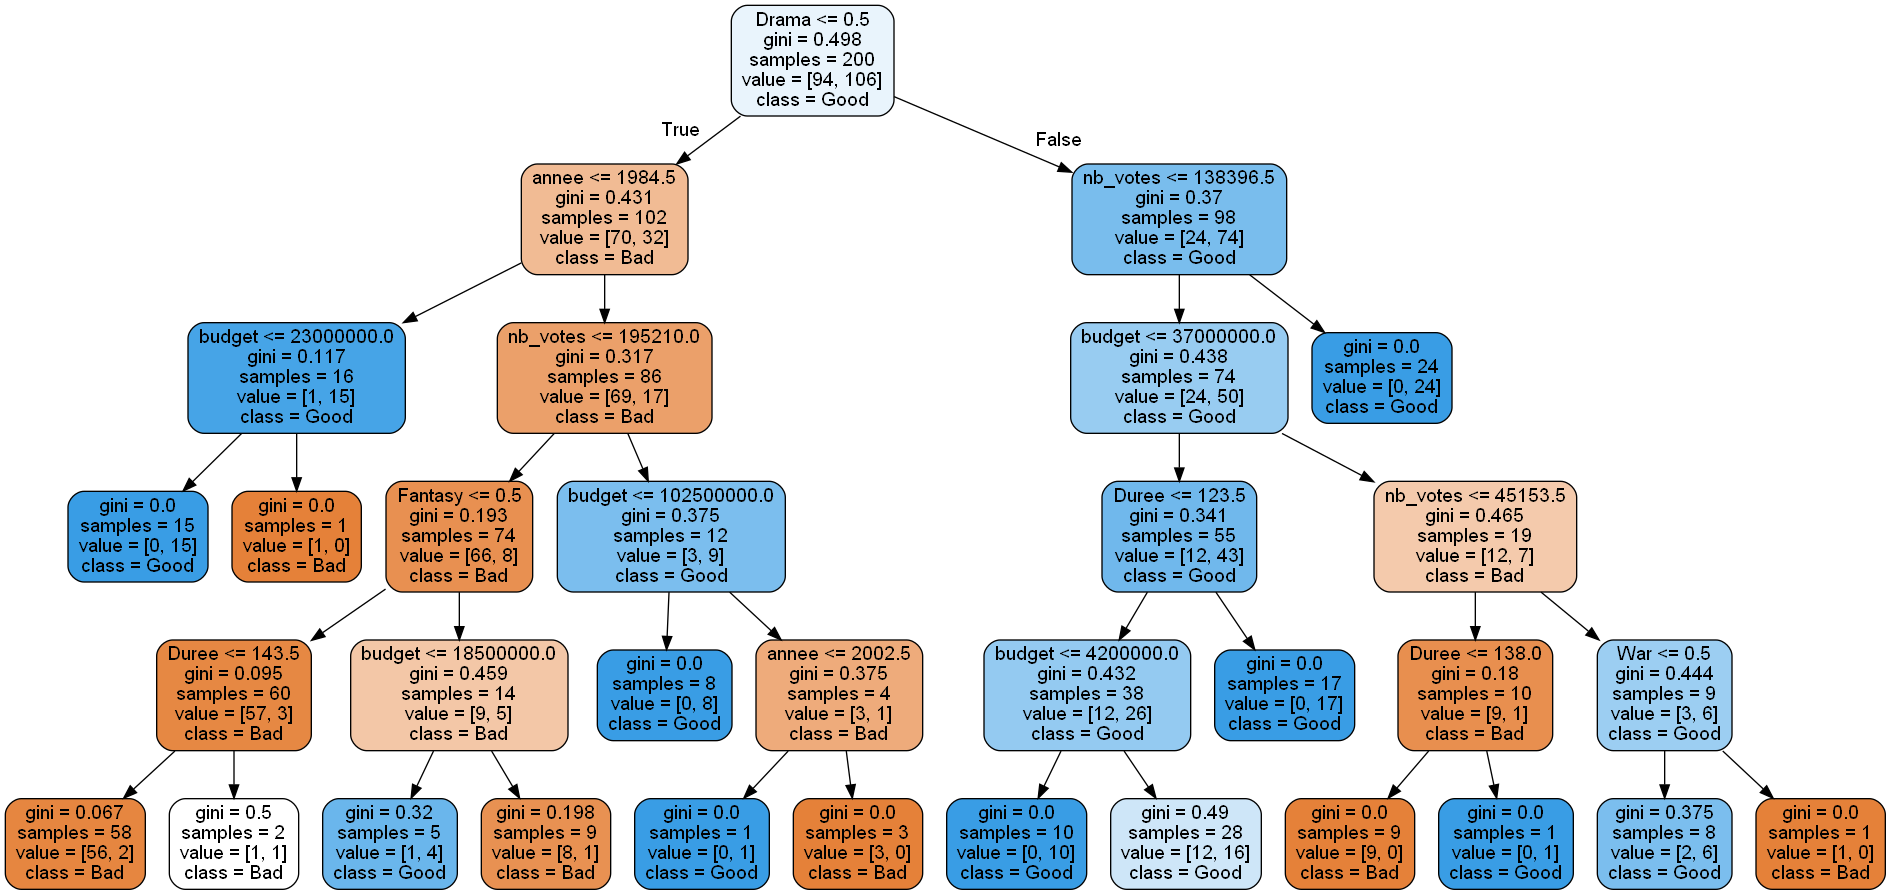

train score :  0.955


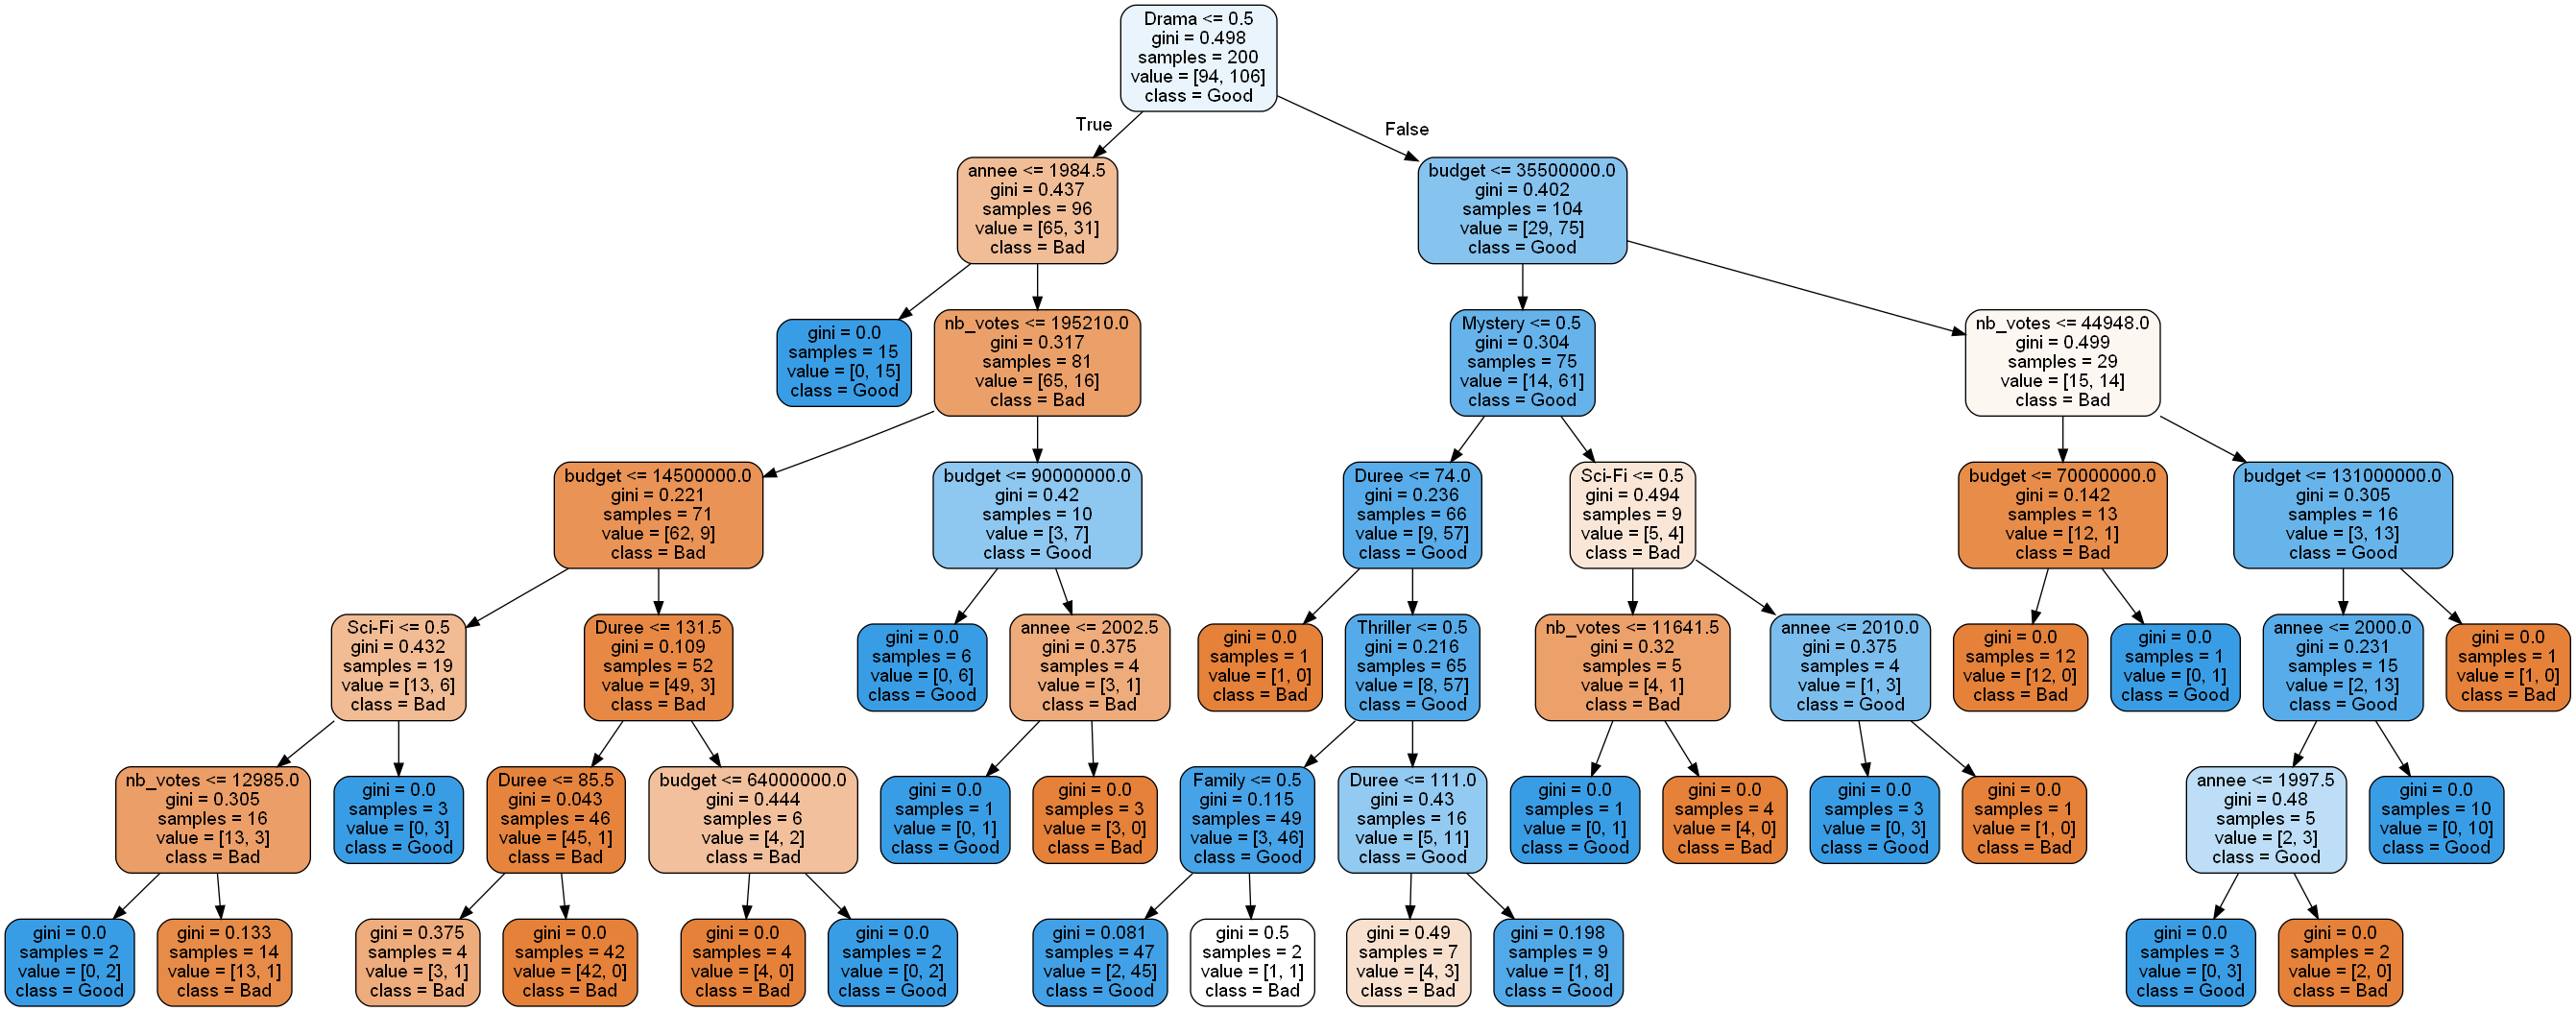

train score :  0.955


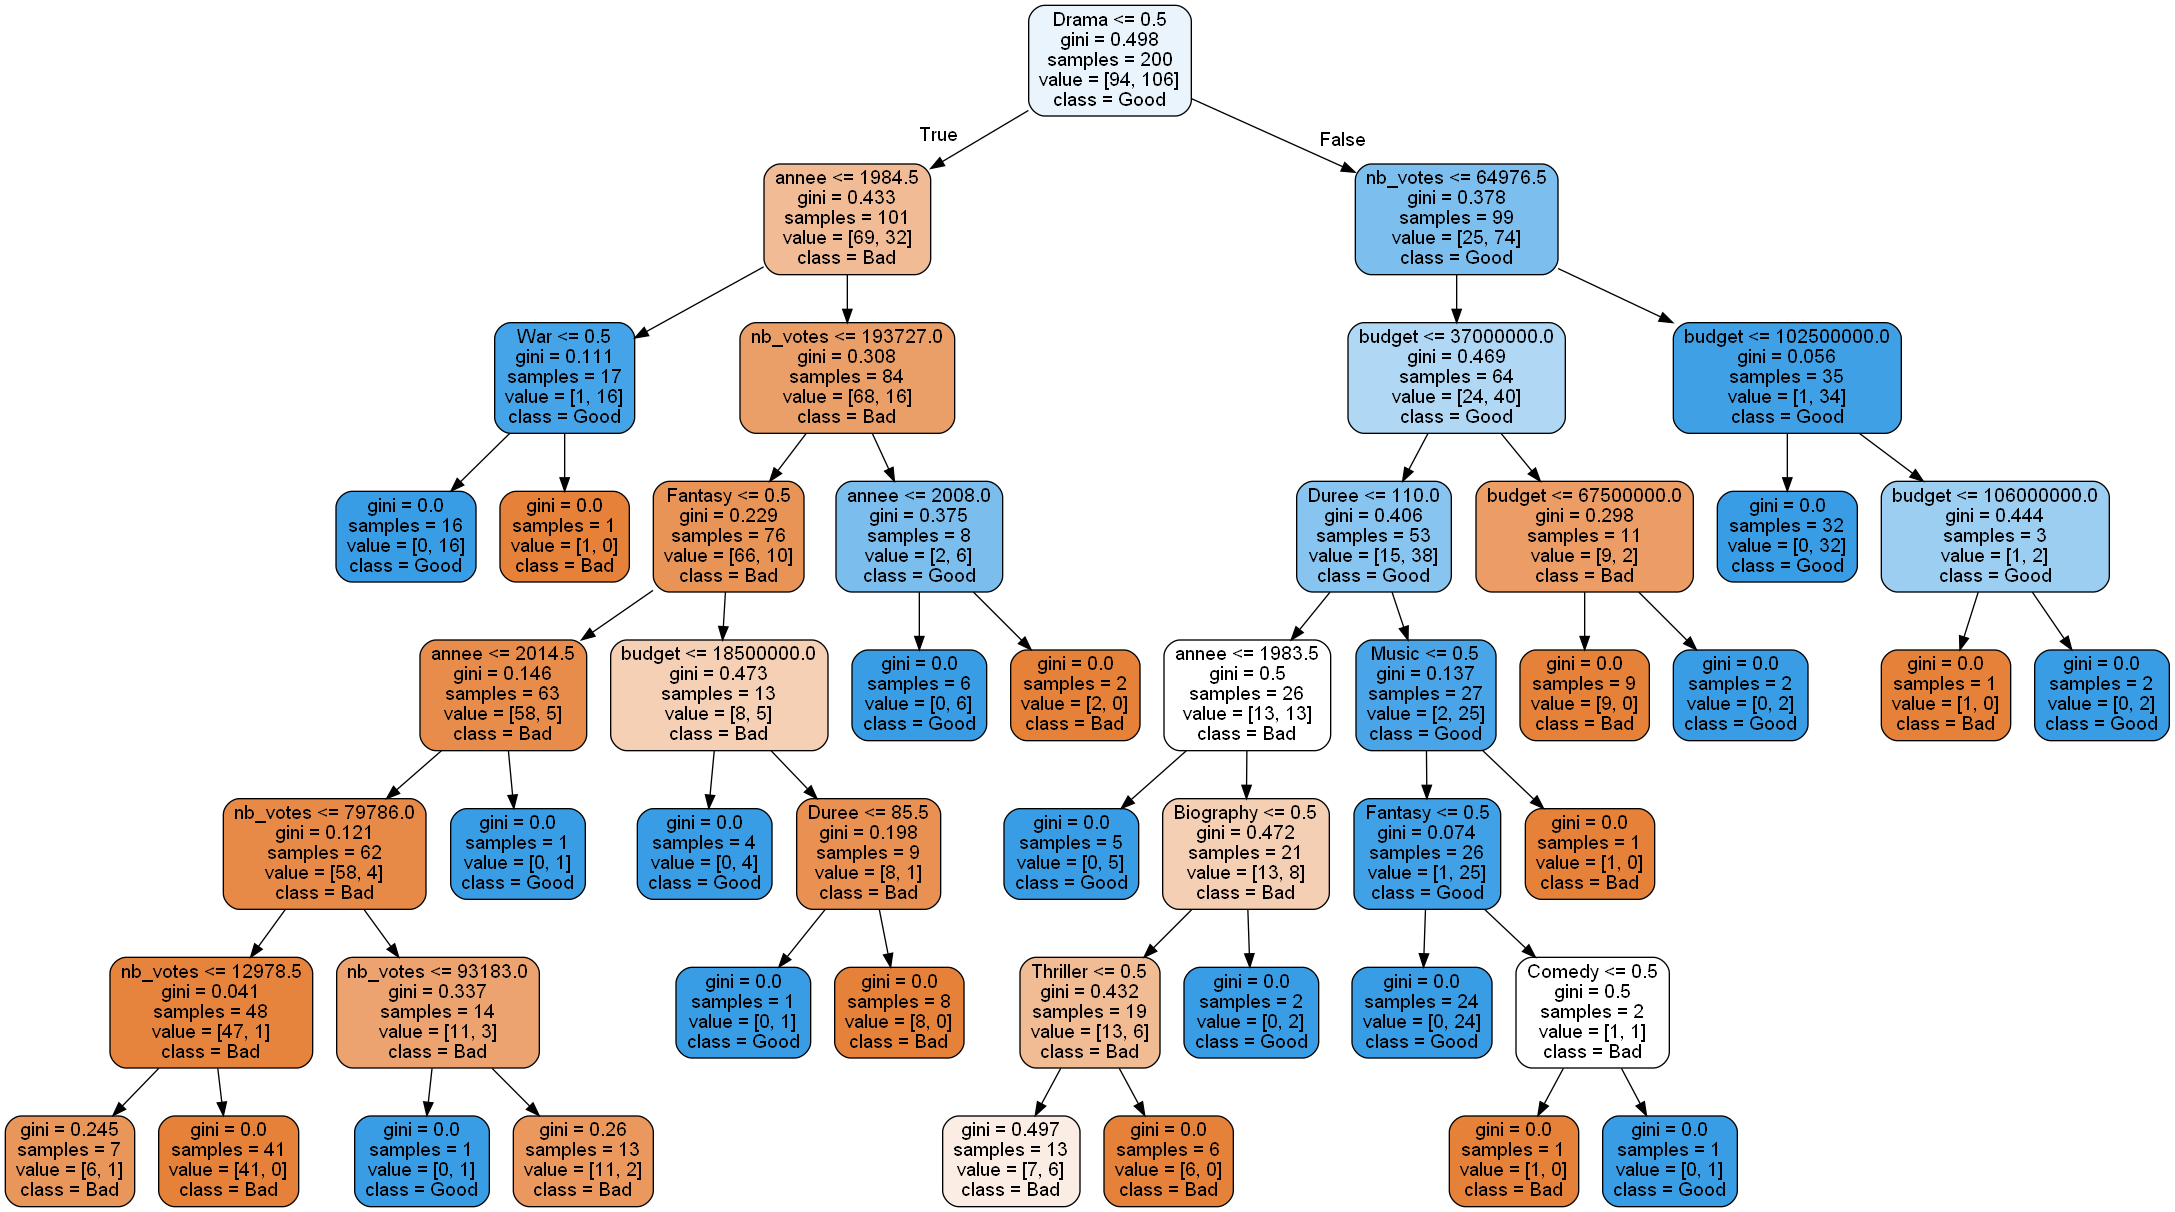

train score :  0.99


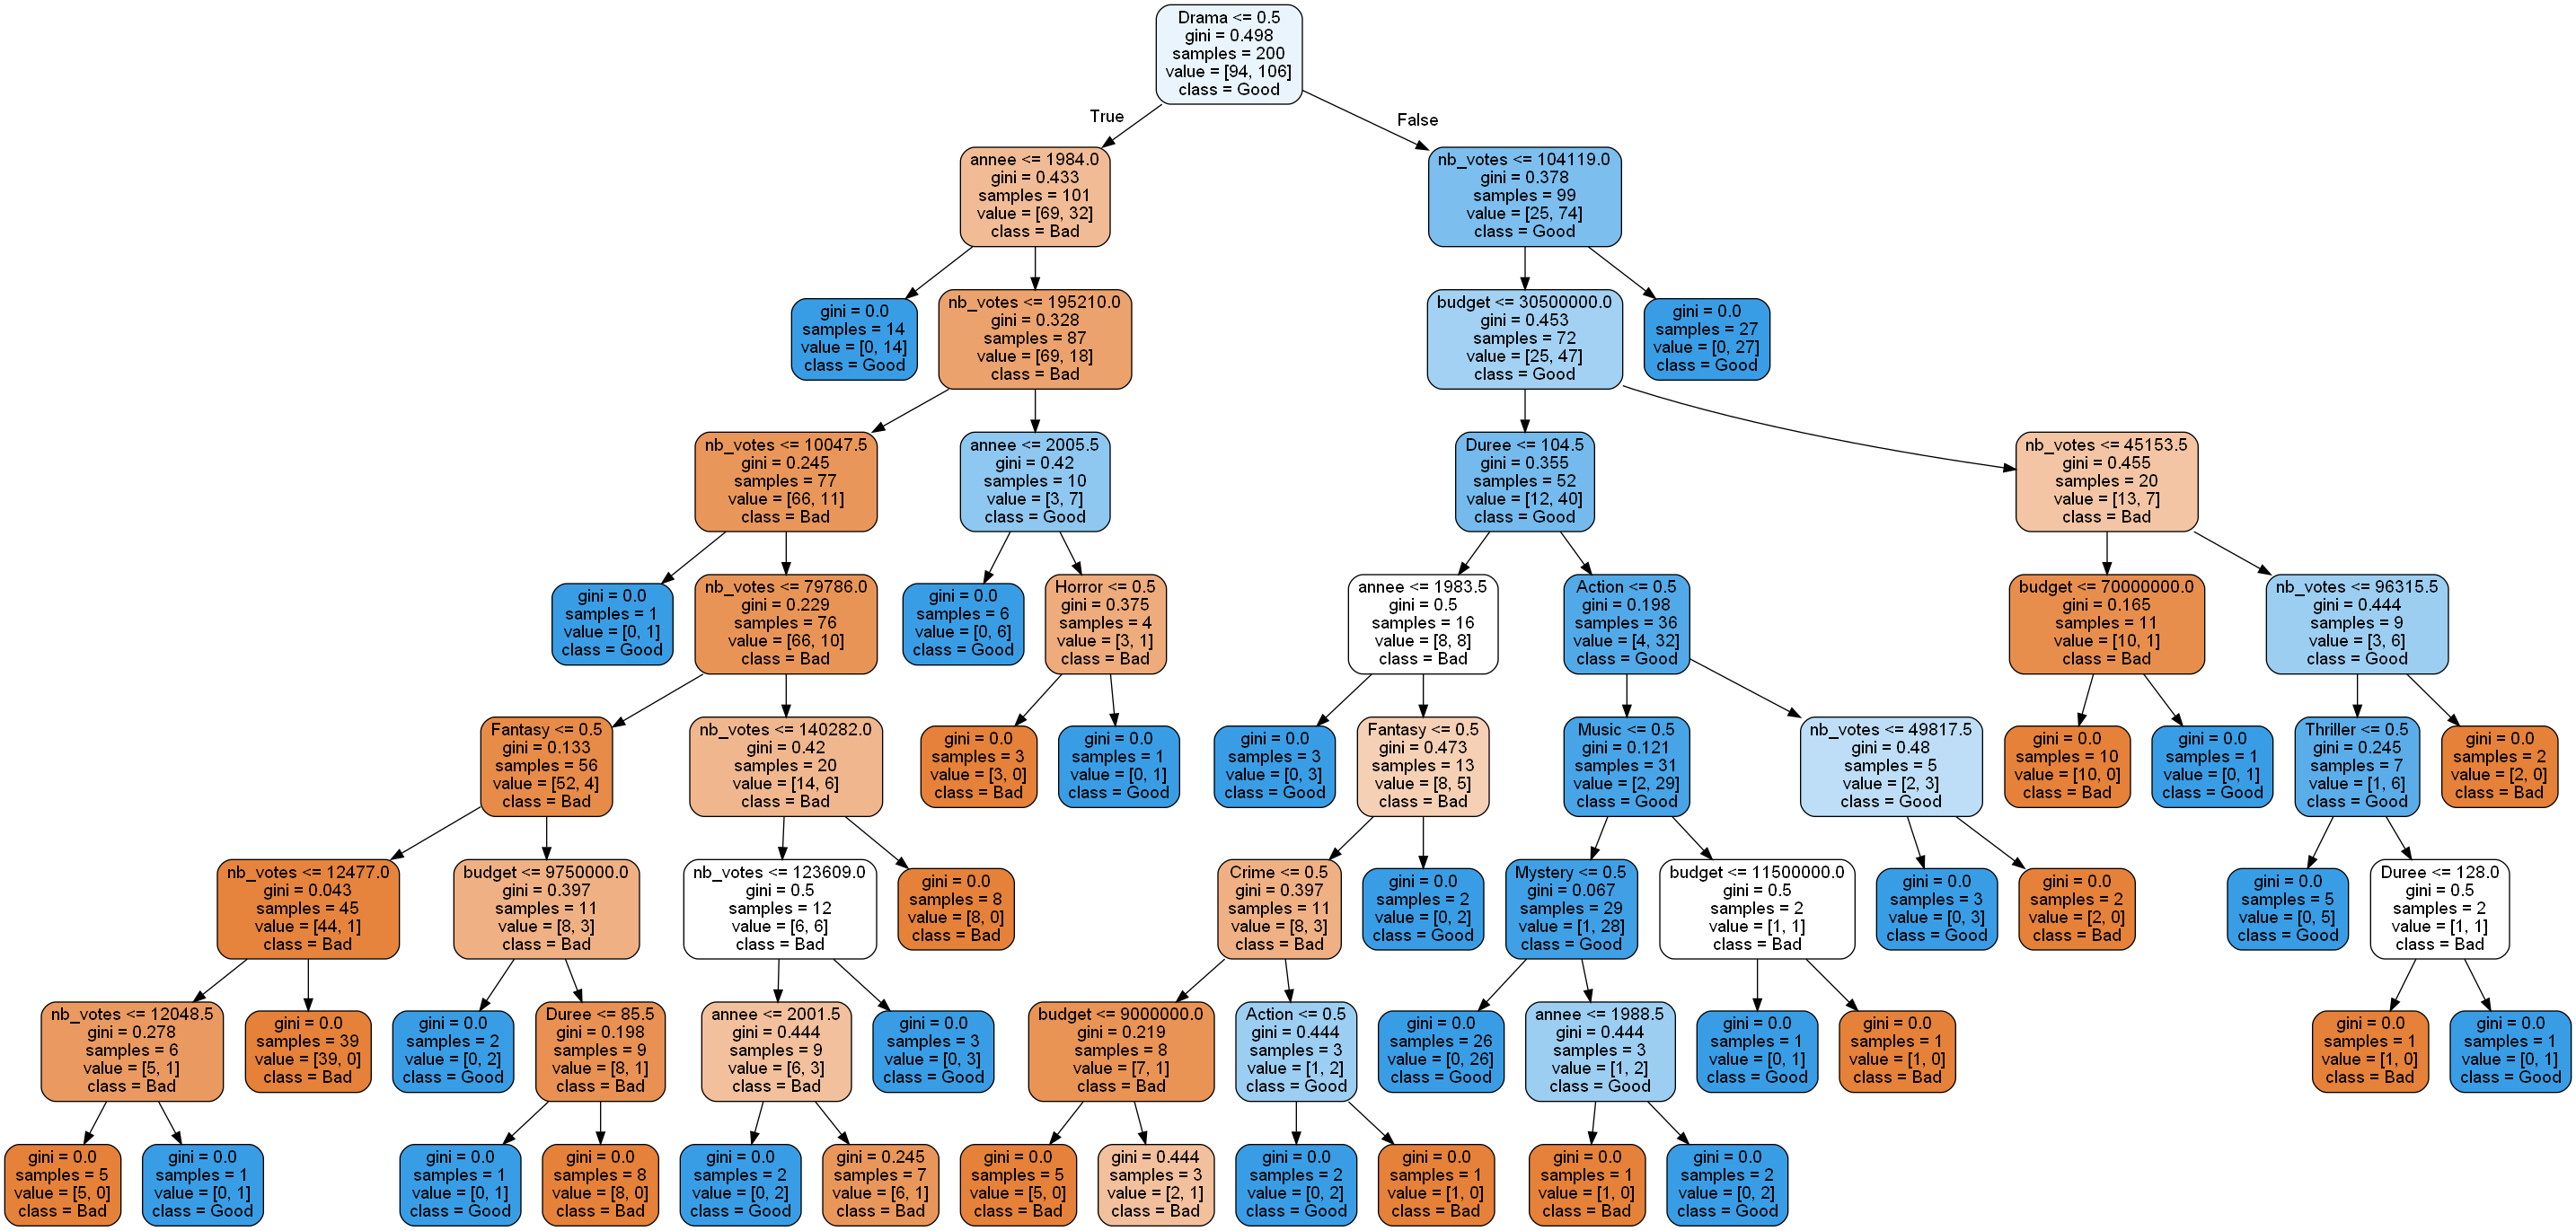

train score :  1.0


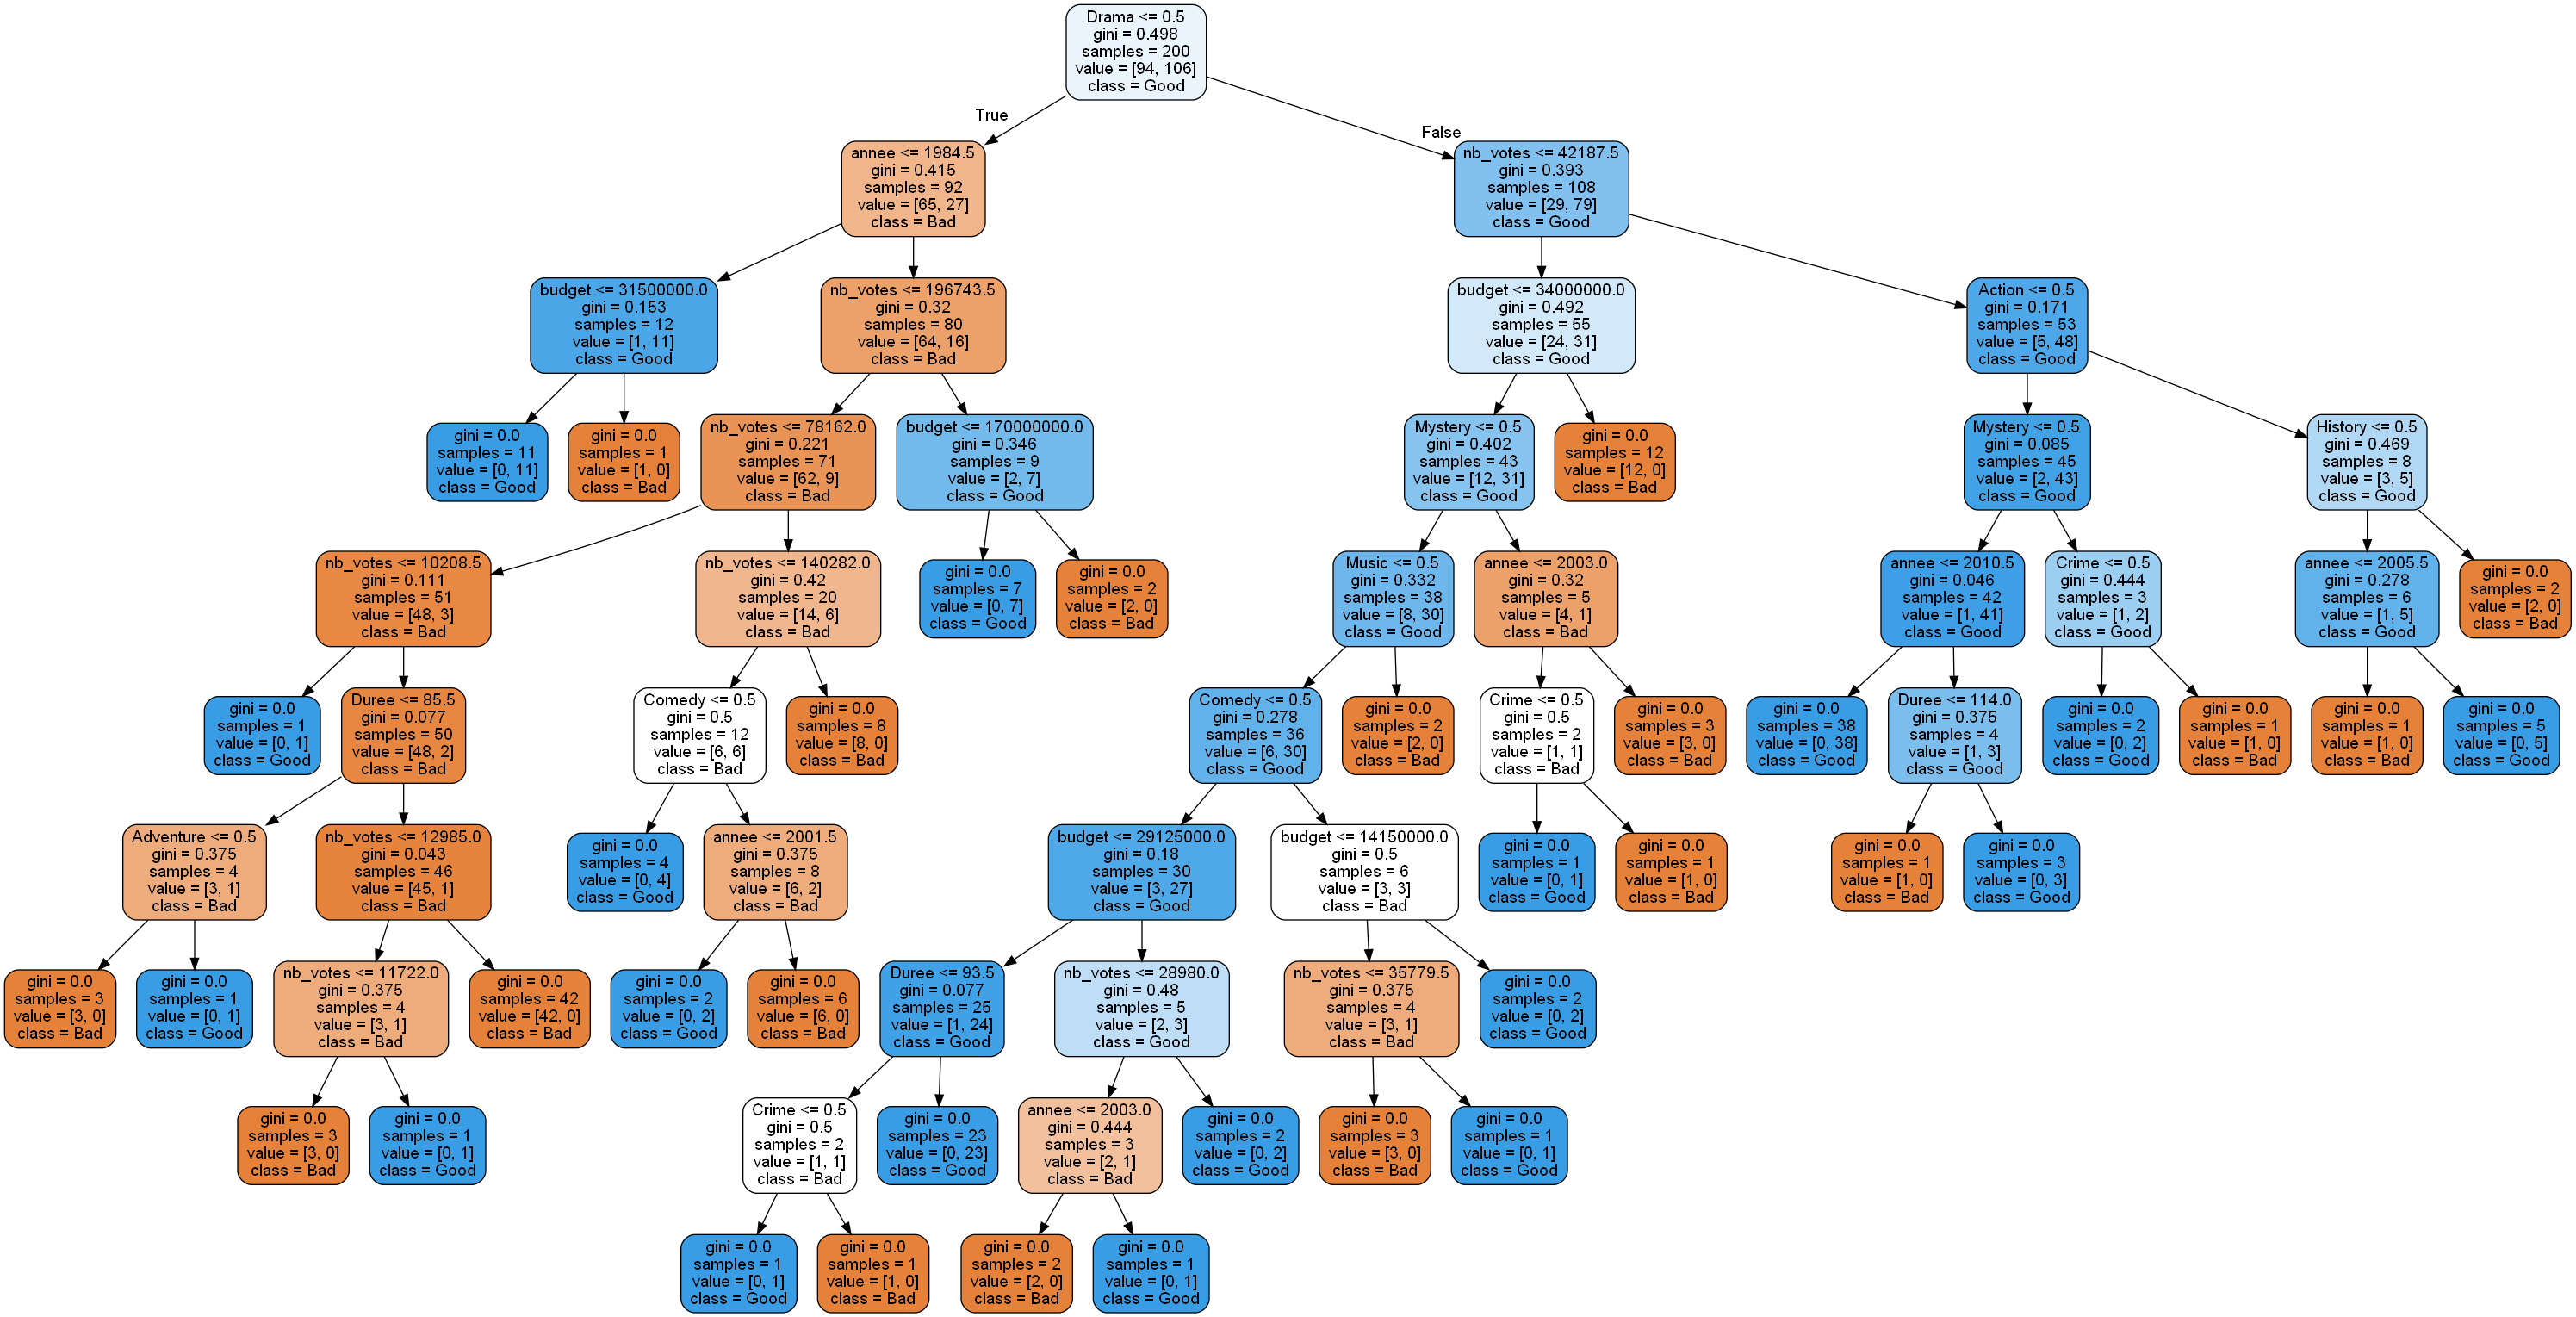

train score :  1.0


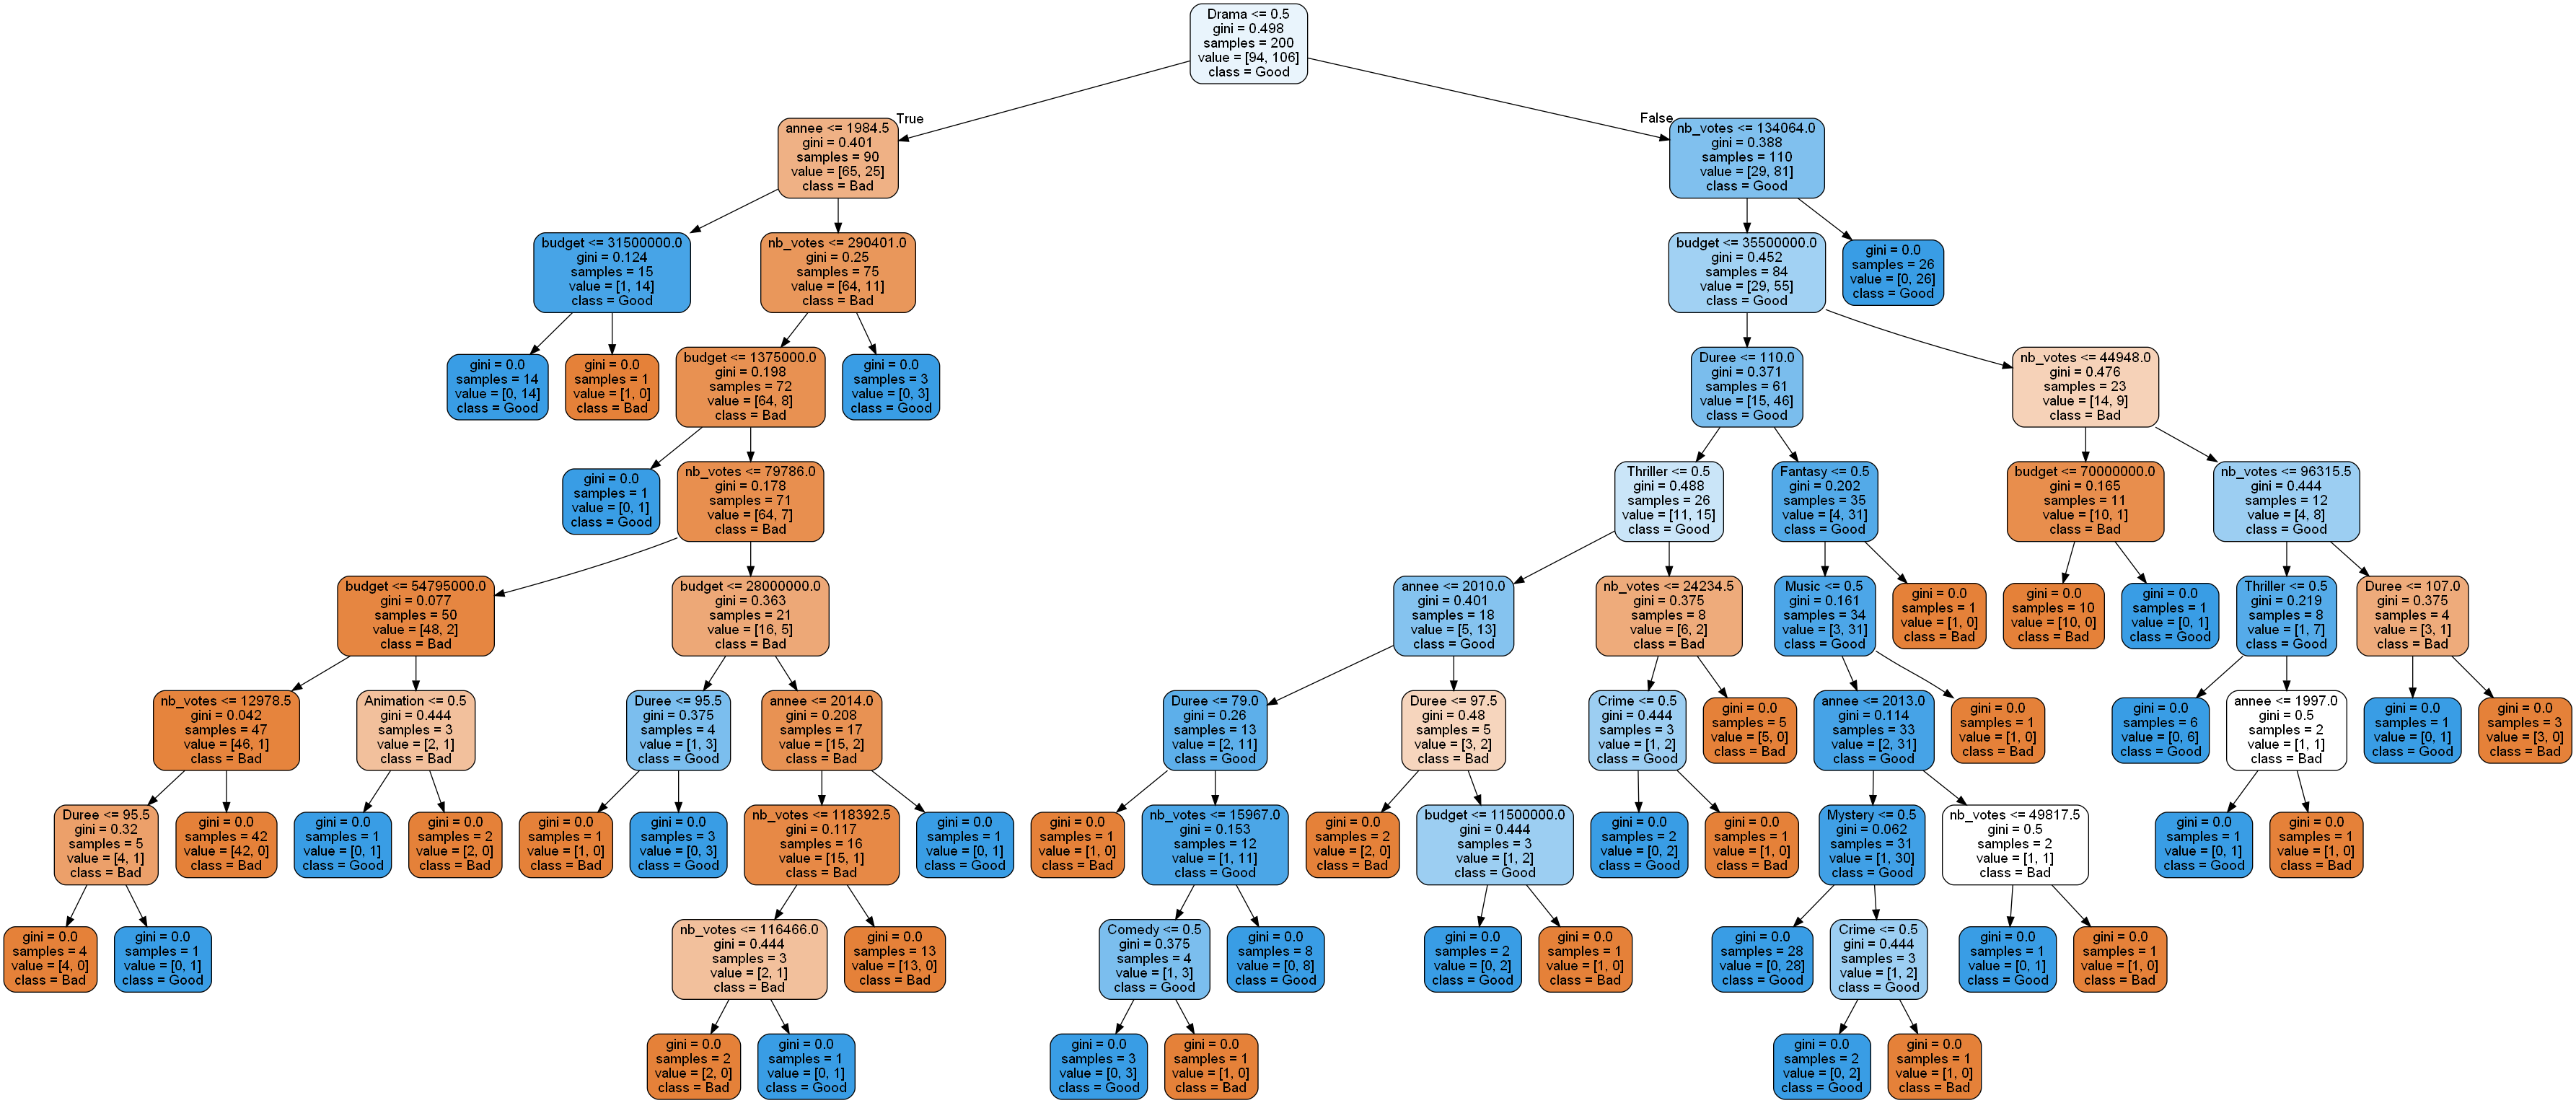

NameError: name 'label' is not defined

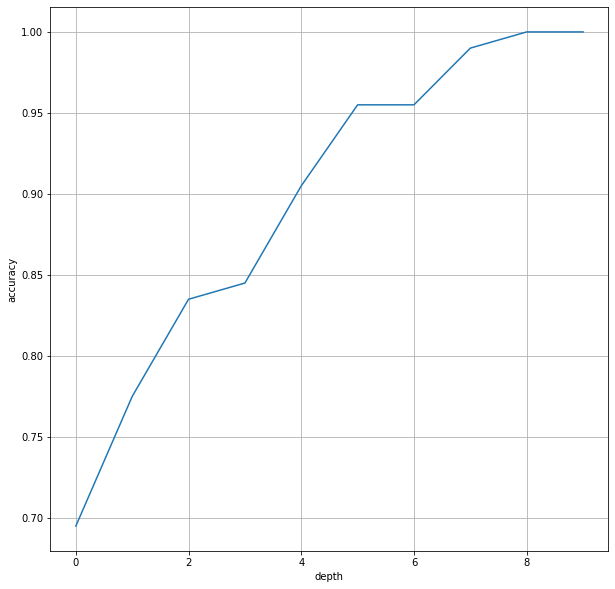

In [59]:

def show_tree(dt, name=""):
    """
    dt: DecisionTree
    """


    # dessine l’arbre dans un fichier pdf si pydot est installe .
    export_graphviz (dt,
                     out_file = name + ".dot",
                     feature_names = df.columns[:-1],
                     class_names = ["Bad", "Good"],
                     rounded = True,
                     filled= True)
    !dot -Tpng {name}.dot -o {name}.png
    display(Image(filename=name+".png", embed=True))

import pdb

x, y = df.iloc[train_index, :-1] , df.iloc[train_index, -1]


scores_train = []
scores_test = []

split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

for i, (train_index, test_index) in enumerate(split.split(x, y)):
    
    
    x_train, y_train = x.iloc[train_index, :], y.iloc[train_index]
    x_test, y_test = x.iloc[test_index, :], y.iloc[test_index]
    
    #pdb.set_trace()
    
    dt = DTree (max_depth=i+1, min_samples_split=2)
    dt.fit(x_train , y_train)
    score_train = dt.score(x_train, y_train)
    score_test = dt.score(x_test, y_test)
    
    scores_train.append(score_train)
    scores_test.append(score_test)
    
    
    print ("train score : ", score_train)
    show_tree(dt, f"dt_{i}")

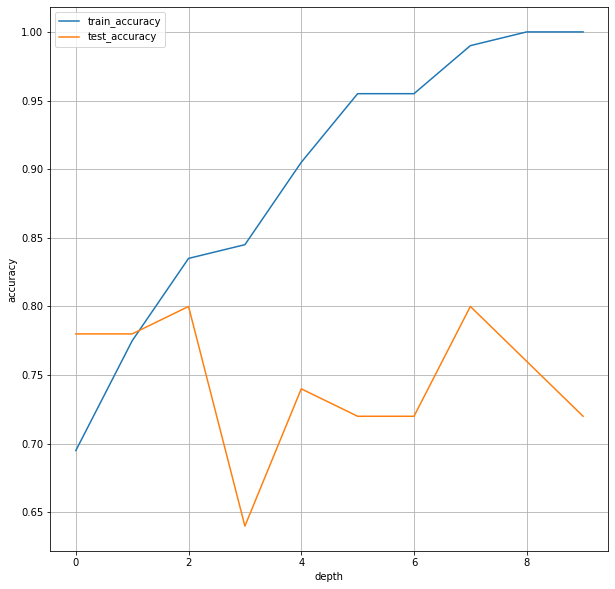

In [62]:
plt.figure(figsize=(10, 10))
plt.ylabel("accuracy")
plt.xlabel("depth")
plt.grid()
plt.plot(scores_train, label="train_accuracy")
plt.plot(scores_test, label="test_accuracy")
plt.legend()